# Task 1

In [10]:
import sys
import os
sys.path.append("../") # go to parent dir

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bct import normalize
from itertools import combinations
from scipy.stats import false_discovery_control

from my_src.utils import load_connectome 
from my_src.clinical_group import ClinicalGroup 
from my_src.statistics import compute_max_t_stat, permutation_testing
from my_src import constants

%load_ext autoreload
%autoreload 2

figures_folder = "../writeup/figures/"

## Qualitative observations on connectome properties

Connectome Shape (84, 84) 
Tau Region List Length = 84


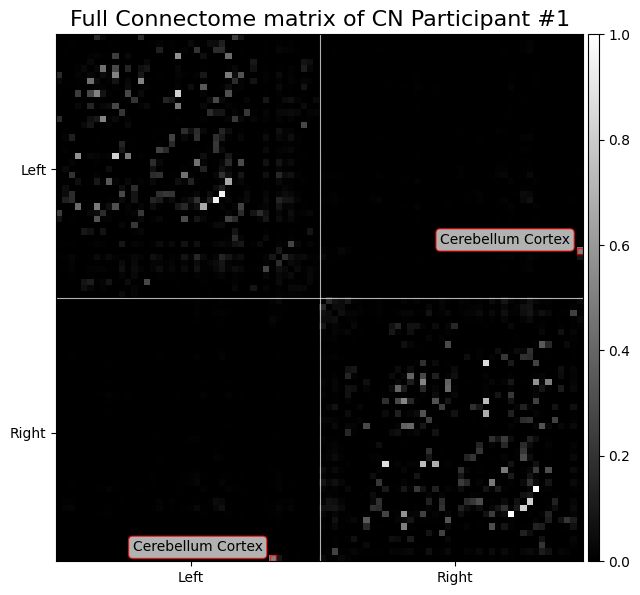

In [17]:
filename = "connectome_cn_0_full.pdf"

# Load and process tau region list
tau_region_list = pd.read_csv("../data/TauRegionList.csv")
tau_region_list["Side"] = tau_region_list["Raj_label"].apply(lambda x: x.split("_")[-1])
tau_region_list["Location"] = tau_region_list["Raj_label"].apply(lambda x: x.replace("_L", "").replace("_R", ""))

clinical_group = "CN"
number = 0
# Normalize the connectome before plotting
connectome_CN_0 = normalize(load_connectome(clinical_group, number))
print("Connectome Shape", connectome_CN_0.shape, "\nTau Region List Length =", len(tau_region_list))

# --- Full Connectome Plot ---
fig, ax = plt.subplots(figsize=(7,8))
im = ax.imshow(connectome_CN_0, cmap="gist_gray")

# Add Left/Right labels on x-axis
ax.set_xticks([21, 63])
ax.set_xticklabels(["Left", "Right"])

# Set y-ticks grouped as "Left" (first 42 rows) and "Right" (remaining 42 rows)
# Placing tick labels at the midpoints of each half
ax.set_yticks([21, 63])
ax.set_yticklabels(["Left", "Right"])

# Add title
ax.set_title("Full Connectome matrix of CN Participant #1", fontsize=16, color='black')

# Add light lines marking between hemispheres
ax.axvline(x=41.5, color='white', linestyle='-', linewidth=0.8, alpha=0.7)
ax.axhline(y=41.5, color='white', linestyle='-', linewidth=0.8, alpha=0.7)

# Highlight the elements (34,83) and (83,34) with light boxes
box1 = plt.Rectangle((82.5, 33.5), 1, 1, fill=False, edgecolor='red', linewidth=1, alpha=0.7)
box2 = plt.Rectangle((33.5, 82.5), 1, 1, fill=False, edgecolor='red', linewidth=1, alpha=0.7)
ax.add_patch(box1)
ax.add_patch(box2)

# Annotate "Cerebellum Cortex" at top left of each rectangle
# For box1: top left is at (82.5, 34.5)
ax.annotate("Cerebellum Cortex", xy=(82.5, 34.5), xycoords='data',
            xytext=(-5, 5), textcoords='offset points', color='black', ha='right',
            va='bottom', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.7))
# For box2: top left is at (33.5, 83.5)
ax.annotate("Cerebellum Cortex", xy=(33.5, 83.5), xycoords='data',
            xytext=(-5, 5), textcoords='offset points', color='black', ha='right',
            va='bottom', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.7))

# Add a narrower colorbar with the same height as the plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(im, cax=cax)

# Save the full connectome plot
plt.savefig(os.path.join(figures_folder, filename), bbox_inches='tight')
plt.show()

Reordering right hemisphere connectome matrix according to left hemisphere labels.


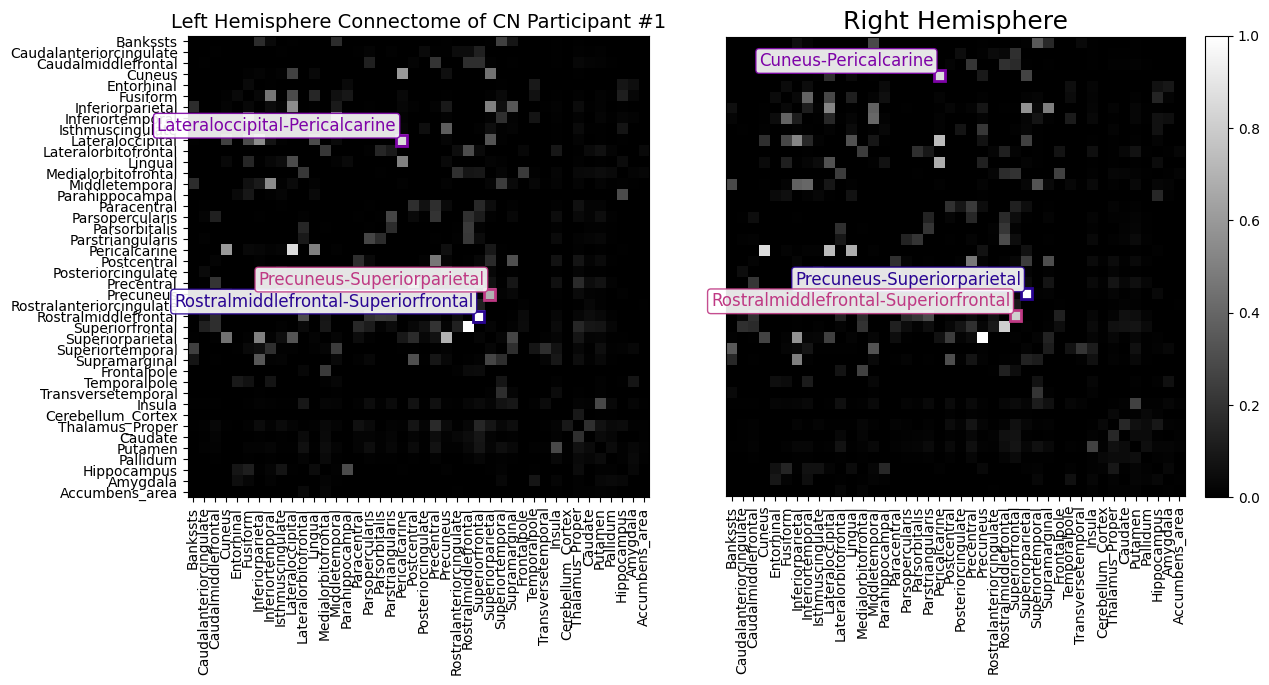

Top 3 Pairs in Left Hemisphere:
Rank 1: Rostralmiddlefrontal - Superiorfrontal, value: 0.9437
Rank 2: Lateraloccipital - Pericalcarine, value: 0.8141
Rank 3: Precuneus - Superiorparietal, value: 0.6577

Top 3 Pairs in Right Hemisphere:
Rank 1: Precuneus - Superiorparietal, value: 1.0000
Rank 2: Cuneus - Pericalcarine, value: 0.8656
Rank 3: Rostralmiddlefrontal - Superiorfrontal, value: 0.8104


In [ ]:
filename = "connectome_cn_0_left_vs_right.pdf"

# --- Side by Side Hemisphere Plots ---
# Get left hemisphere labels and right hemisphere labels from tau_region_list
left_labels = tau_region_list.iloc[:42]["Location"].tolist()
right_labels = tau_region_list.iloc[42:]["Location"].tolist()

# Rearrange right_mat if orders differ
if left_labels != right_labels:
    # Create mapping: for each label in left_labels, find its index in right_labels.
    new_order = [right_labels.index(lbl) for lbl in left_labels if lbl in right_labels]
    # Warning: This assumes that all left labels are present in right_labels.
    print("Reordering right hemisphere connectome matrix according to left hemisphere labels.")
else:
    new_order = list(range(42))

# Extract hemisphere matrices
left_mat = connectome_CN_0[:42, :42]
right_mat = connectome_CN_0[42:, 42:]
# Reorder the right hemisphere matrix rows and columns if necessary
if new_order != list(range(42)):
    right_mat = right_mat[np.ix_(new_order, new_order)]
    right_labels = [right_labels[i] for i in new_order]

fig, axs = plt.subplots(1, 2, figsize=(13,6.5))

# Left Hemisphere Plot
im_left = axs[0].imshow(left_mat, cmap="gist_gray")
axs[0].set_title("Left Hemisphere", fontsize=18)
axs[0].set_xticks(np.arange(42))
axs[0].set_yticks(np.arange(42))
axs[0].set_xticklabels(left_labels, rotation=90)
axs[0].set_yticklabels(left_labels)
axs[0].set_aspect('equal')   # Ensure each cell is square

# Right Hemisphere Plot
im_right = axs[1].imshow(right_mat, cmap="gist_gray")
axs[1].set_title("Right Hemisphere", fontsize=18)
axs[1].set_xticks(np.arange(42))
axs[1].set_xticklabels(left_labels, rotation=90)  # sharing left hemisphere labels for consistent order
axs[1].set_yticks([])
axs[1].set_aspect('equal')   # Ensure each cell is square
plt.colorbar(im_right, ax=axs[1], fraction=0.046, pad=0.04)

# ---- Add Annotations for Top 3 Pairs in each Hemisphere ----
import numpy as np

# Define colors for 1st, 2nd, 3rd pairs using plasma colormap shades
color_list = [plt.cm.plasma(0.05), plt.cm.plasma(0.25), plt.cm.plasma(0.45)]

# For the Left Hemisphere: consider only the upper triangle (excluding diagonal)
mask_left = np.triu(np.ones_like(left_mat, dtype=bool), k=1)
r_left, c_left = np.where(mask_left)
left_values = left_mat[r_left, c_left]
order_left = np.argsort(left_values)[::-1]  # descending order
top3_left = order_left[:3]

for rank, idx in enumerate(top3_left):
    i = r_left[idx]
    j = c_left[idx]
    color = color_list[rank]
    # Draw rectangle around the element; note imshow uses (col, row) coordinates.
    rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor=color, lw=2)
    axs[0].add_patch(rect)
    # Annotate with text showing the node labels
    axs[0].text(j - 0.5, i - 0.5, f"{left_labels[i]}-{left_labels[j]}", 
                color=color, fontsize=12, verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color, alpha=0.9))

# For the Right Hemisphere: consider only the upper triangle (excluding diagonal)
mask_right = np.triu(np.ones_like(right_mat, dtype=bool), k=1)
r_right, c_right = np.where(mask_right)
right_values = right_mat[r_right, c_right]
order_right = np.argsort(right_values)[::-1]
top3_right = order_right[:3]

for rank, idx in enumerate(top3_right):
    i = r_right[idx]
    j = c_right[idx]
    color = color_list[rank]
    rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor=color, lw=2)
    axs[1].add_patch(rect)
    axs[1].text(j - 0.5, i - 0.5, f"{left_labels[i]}-{left_labels[j]}", 
                color=color, fontsize=12, verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color, alpha=0.9))

plt.tight_layout()
plt.savefig(os.path.join(figures_folder, filename), bbox_inches='tight')
plt.show()

# ---- Print Top 3 Pairs for both Hemispheres ----
print("Top 3 Pairs in Left Hemisphere:")
for rank, idx in enumerate(top3_left):
    i = r_left[idx]
    j = c_left[idx]
    print(f"Rank {rank+1}: {left_labels[i]} - {left_labels[j]}, value: {left_mat[i, j]:.4f}")

print("\nTop 3 Pairs in Right Hemisphere:")
for rank, idx in enumerate(top3_right):
    i = r_right[idx]
    j = c_right[idx]
    print(f"Rank {rank+1}: {left_labels[i]} - {left_labels[j]}, value: {right_mat[i, j]:.4f}")

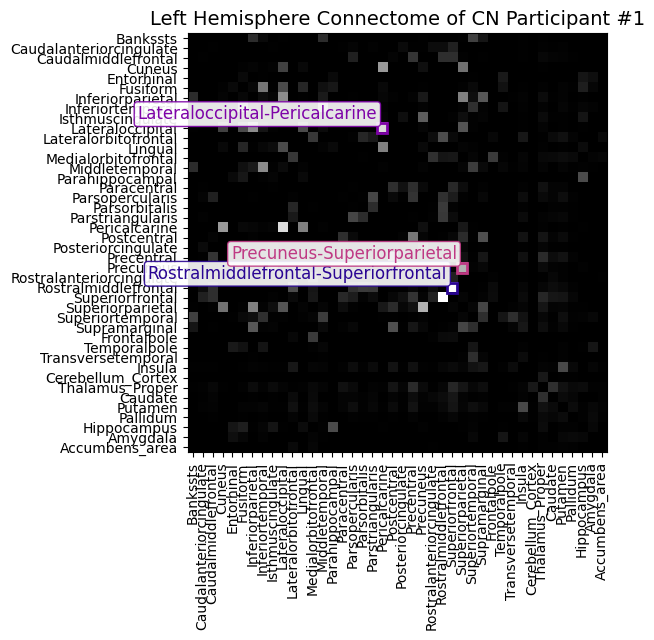

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Left hemisphere labels and matrix
left_labels = tau_region_list.iloc[:42]["Location"].tolist()
left_mat = connectome_CN_0[:42, :42]

fig, ax = plt.subplots(figsize=(7, 6.5))

# Plot left hemisphere connectivity matrix
im = ax.imshow(left_mat, cmap="gist_gray")
ax.set_title("Left Hemisphere Connectome of CN Participant #1", fontsize=14)
ax.set_xticks(np.arange(42))
ax.set_yticks(np.arange(42))
ax.set_xticklabels(left_labels, rotation=90)
ax.set_yticklabels(left_labels)
ax.set_aspect('equal')  # Ensure each cell is square

# ---- Add Annotations for Top 3 Pairs in Left Hemisphere ----
# Only consider the upper triangle (excluding diagonal)
mask_left = np.triu(np.ones_like(left_mat, dtype=bool), k=1)
r_left, c_left = np.where(mask_left)
left_values = left_mat[r_left, c_left]
order_left = np.argsort(left_values)[::-1]  # descending order
top3_left = order_left[:3]

# Define colors for the 1st, 2nd, and 3rd pairs using plasma colormap shades
color_list = [plt.cm.plasma(0.05), plt.cm.plasma(0.25), plt.cm.plasma(0.45)]

for rank, idx in enumerate(top3_left):
    i = r_left[idx]
    j = c_left[idx]
    color = color_list[rank]
    # Draw rectangle around the element (note: imshow uses (col, row) coordinates)
    rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor=color, lw=2)
    ax.add_patch(rect)
    # Annotate with text showing the node labels
    ax.text(j - 0.5, i - 0.5, f"{left_labels[i]}-{left_labels[j]}", color=color, fontsize=12,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color, alpha=0.9))

plt.tight_layout()
plt.savefig(os.path.join(figures_folder, "connectome_cn_0_left.pdf"), bbox_inches='tight')
plt.show()

Reordering right hemisphere connectome matrix according to left hemisphere labels.


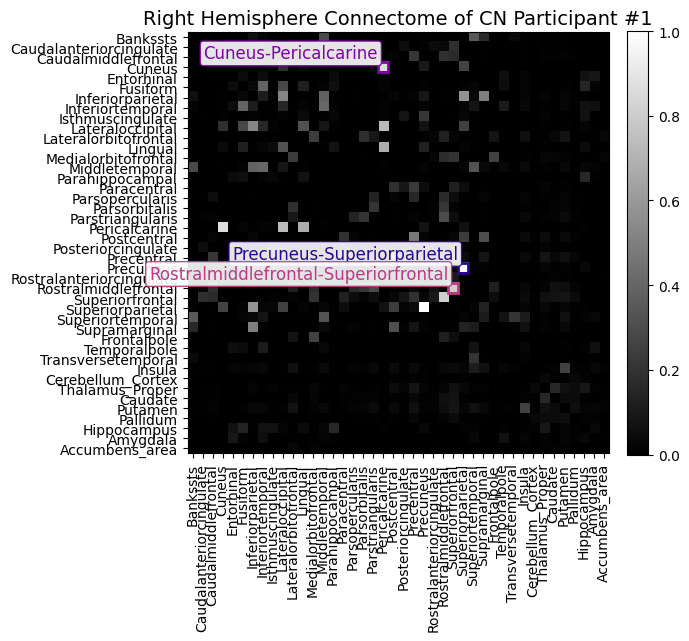

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Right hemisphere labels and matrix
left_labels = tau_region_list.iloc[:42]["Location"].tolist()
right_labels = tau_region_list.iloc[42:]["Location"].tolist()

# Rearrange right_mat if the order differs from left hemisphere labels
if left_labels != right_labels:
    new_order = [right_labels.index(lbl) for lbl in left_labels if lbl in right_labels]
    print("Reordering right hemisphere connectome matrix according to left hemisphere labels.")
else:
    new_order = list(range(42))

right_mat = connectome_CN_0[42:, 42:]
if new_order != list(range(42)):
    right_mat = right_mat[np.ix_(new_order, new_order)]
    right_labels = [right_labels[i] for i in new_order]

fig, ax = plt.subplots(figsize=(7, 6.5))

# Plot right hemisphere connectivity matrix
im = ax.imshow(right_mat, cmap="gist_gray")
ax.set_title("Right Hemisphere Connectome of CN Participant #1", fontsize=14)
ax.set_xticks(np.arange(42))
ax.set_yticks(np.arange(42))
ax.set_xticklabels(left_labels, rotation=90)  # use left_labels to ensure consistent ordering
ax.set_yticklabels(right_labels)
ax.set_aspect('equal')  # Ensure each cell is square
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# ---- Add Annotations for Top 3 Pairs in Right Hemisphere ----
# Consider only the upper triangle (excluding diagonal)
mask_right = np.triu(np.ones_like(right_mat, dtype=bool), k=1)
r_right, c_right = np.where(mask_right)
right_values = right_mat[r_right, c_right]
order_right = np.argsort(right_values)[::-1]  # descending order
top3_right = order_right[:3]

# Use same plasma colormap shades for the top pairs
color_list = [plt.cm.plasma(0.05), plt.cm.plasma(0.25), plt.cm.plasma(0.45)]

for rank, idx in enumerate(top3_right):
    i = r_right[idx]
    j = c_right[idx]
    color = color_list[rank]
    rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor=color, lw=2)
    ax.add_patch(rect)
    ax.text(j - 0.5, i - 0.5, f"{left_labels[i]}-{left_labels[j]}", color=color, fontsize=12,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color, alpha=0.9))

plt.tight_layout()
plt.savefig(os.path.join(figures_folder, "connectome_cn_0_right.pdf"), bbox_inches='tight')
plt.show()

In [4]:
group_connectomes = dict()

clinical_groups = dict()
for name in constants.clinical_group_names:
    clinical_groups[name] = ClinicalGroup(name)
    clinical_groups[name].compute_metrics(constants.metric_functions.keys())

Error computing metric diffusion_efficiency for participant LMCI:40.
Error computing metric diffusion_efficiency for participant DEM:24.


In [14]:
n_perm = 20000
pairs = combinations(clinical_groups, 2)
results = []
for p in pairs:
    for metric_name in constants.metric_functions.keys():
        a_name, b_name = p
        a_values = clinical_groups[a_name].metrics[metric_name] 
        b_values = clinical_groups[b_name].metrics[metric_name]
        
        p_value, t_statistics = permutation_testing(a_values, b_values, n_perm = n_perm)
        a_mean = a_values.mean()
        b_mean = b_values.mean()
        
        results.append({
            "group A": a_name, 
            "group B": b_name,
            "Metric": metric_name.title().replace("_"," "),
            "A mean": a_mean, 
            "B mean": b_mean, 
            "T-Statistic": t_statistics[0],
            "P value": p_value
        })
results_df = pd.DataFrame(results)

In [15]:
# results_df["A mean"] = results_df["A mean"].apply(lambda x: '{:.3e}'.format(x))
# results_df["B mean"] = results_df["B mean"].apply(lambda x: '{:.3e}'.format(x))
results_df["Benjamini-Hochberg Controlled P value"] = false_discovery_control(results_df["P value"]) 
results_df["delta"] = (results_df["B mean"] - results_df["A mean"])/ results_df["A mean"]
results_df[["group A","group B","Metric","A mean","B mean","Benjamini-Hochberg Controlled P value","P value","T-Statistic"]]

,group A,group B,Metric,A mean,B mean,Benjamini-Hochberg Controlled P value,P value,T-Statistic
0,CN,EMCI,Clustering Coefficient,0.004583,0.004273,0.094773,0.03475,3.380824
1,CN,EMCI,Node Degree,68.356009,67.837868,0.302605,0.19165,2.919825
2,CN,EMCI,Global Efficiency,0.056355,0.052111,0.049250,0.00985,2.659468
3,CN,EMCI,Node Strength,1.326184,1.243145,0.071167,0.02085,3.666595
4,CN,EMCI,Diffusion Efficiency,0.008826,0.008718,0.123000,0.05740,1.924187
5,CN,LMCI,Clustering Coefficient,0.004583,0.004419,0.071167,0.02135,3.575252
6,CN,LMCI,Node Degree,68.356009,68.487528,0.312429,0.21870,2.885448
7,CN,LMCI,Global Efficiency,0.056355,0.053063,0.159100,0.07955,1.782546
8,CN,LMCI,Node Strength,1.326184,1.269075,0.109962,0.04765,3.384214
9,CN,LMCI,Diffusion Efficiency,0.008826,0.008816,0.869900,0.86990,0.168834


# Task 2

In [16]:
from nsm_toolbox.src import network_diffusion_model, FKPP_model
from nsm_toolbox.src.find_optimal_timepoint import find_optimal_timepoint
from nsm_toolbox.src.ModelSelection import ModelSelection
from scipy.stats import pearsonr 


In [4]:
for clinical_group_name in constants.clinical_group_names:
    np.savetxt(fname=constants.average_connectome_path.format(clinical_group_name = clinical_group_name),
               X=clinical_groups[clinical_group_name].average_connectomes,
               delimiter=",")

In [11]:
def normalise_data(data):
    ''' min-max normalise the data '''
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# load in target data
tau = pd.read_csv("data/PET/tau_ab+_tau+.csv", names=["region", "suvr"], header=0)
target_data = tau["suvr"].values

# remove the subcortical regions, since these are affected by off-target binding of the tau-PET tracer
CORT_IDX = np.concatenate([np.arange(34), np.arange(49, 83)])
target_data = target_data[CORT_IDX]
target_data = normalise_data(target_data)

In [6]:
region_list = pd.read_csv( "data/TauRegionList.csv")["Raj_label"].tolist()
connectome_path = "data/connectomes/CN/CN_0.csv" # the path where the connectome is stored
t = np.arange(0, 50, 0.1) # define the timepoints for our model evaluation
gamma = 1 # define gamma: the diffusion constant (we set this to 1 since we are not calibrating our time units to any real-world time)

In [ ]:
ndm_results = []
for clinical_group_name in constants.clinical_group_names:
    average_connectome_path = constants.average_connectome_path.format(clinical_group_name = clinical_group_name)
    model = network_diffusion_model.NDM(connectome_fname=average_connectome_path, # set up our network diffusion model class with the connectome, timepoints, gamma, and reference list
                                  t=t,
                                  gamma = gamma,
                                  ref_list=region_list)
    df, optimal_seed = model.optimise_seed_region(target_data)
    model.seed_region = optimal_seed["seed"]
    model_output = model.run_NDM()
    min_idx, prediction, SSE = find_optimal_timepoint(model_output, target_data)
    r = pearsonr(prediction, target_data)[0]
    ndm_results.append(dict(
        clinical_group_name = clinical_group_name,
        seed_region = model.seed_region,
        r = r
    ))
    
    clinical_group = clinical_groups[clinical_group_name]
    clinical_group.residual = np.abs()

ndm_results = pd.DataFrame(ndm_results)
ndm_results

,clinical_group_name,seed_region,r
0,CN,Inferiortemporal,0.724365
1,EMCI,Inferiortemporal,0.718787
2,LMCI,Inferiortemporal,0.718020
3,DEM,Inferiortemporal,0.714331


In [ ]:
fkpp_results = []
for clinical_group_name in constants.clinical_group_names:
    average_connectome_path = constants.average_connectome_path.format(clinical_group_name = clinical_group_name)
    model = FKPP_model.FKPP(connectome_fname=average_connectome_path, # set up our network diffusion model class with the connectome, timepoints, gamma, and reference list
                                  t=t,
                                  gamma = gamma,
                                  ref_list=region_list,
                                  )
    df, optimal_parameters = model.optimise_fkpp(target_data)
    model.seed_region = optimal_parameters["seed"]
    model.alpha = optimal_parameters["alpha"]
    model_output = model.run_FKPP()
    min_idx, prediction, SSE = find_optimal_timepoint(model_output, target_data)
    r = pearsonr(prediction, target_data)[0]
    fkpp_results.append(dict(
        clinical_group_name = clinical_group_name,
        seed_region = model.seed_region,
        r = r
    ))

fkpp_results = pd.DataFrame(fkpp_results)
fkpp_results

,clinical_group_name,seed_region,r
0,CN,Inferiortemporal,0.692583
1,EMCI,Inferiortemporal,0.663057
2,LMCI,Inferiortemporal,0.646245
3,DEM,Inferiortemporal,0.619568


In [ ]:
from nsm_toolbox.src.ModelSelection import ModelSelection

residuals = np.random.normal(size=(100,5))
results = ModelSelection([3,3,4,2,3], 'AICc')(residuals)
print(results)

'CN'

In [31]:
low_rank_connectomes = []
for i in range(42):
    try:
        connectomes = load_connectome("LMCI",i)
        np.linalg.inv(connectomes)
    except:
        print(i, "low rank")
        low_rank_connectomes.append(i)
        

40 low rank


In [33]:
np.linalg.matrix_rank(load_connectome("LMCI",40))

np.int64(83)

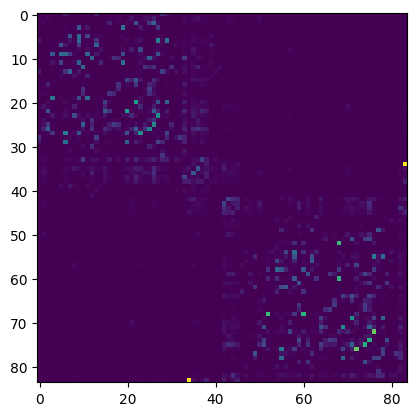

In [32]:
plt.imshow(load_connectome("LMCI",40))

Pip subprocess error:
ERROR: Ignored the following versions that require a different python version: 1.3.1 Requires-Python >=3.10
ERROR: Could not find a version that satisfies the requirement enigmatoolbox==2.0.3 (from versions: none)
ERROR: No matching distribution found for enigmatoolbox==2.0.3

failed

CondaEnvException: Pip failed